In [235]:
import pandas as pd
import seaborn as sns
import pandas
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import ast
#pandas.set_option('display.max_rows', 500)


## Data loading 

In [738]:
# Import data 
df=pd.read_csv('/Users/cxue200/mockdata_v2.csv',index_col=0)


## Pre-processing & Feature engineering

In [739]:
# Data pre-processing and feature engineering
df=df.drop_duplicates()
# rename column
df.rename(columns = {'purchase_index_boolean.x':'purchase_index_boolean'}, inplace = True) 

# Fix data types
df['avg_price_per_night'] = pd.to_numeric(df['avg_price_per_night'],errors='coerce')
df['position_on_search_results'] = pd.to_numeric(df['position_on_search_results'],errors='coerce')
df['property_id'] = df['property_id'].astype('Int32').astype(str).str.strip()

# Count number of properties viewed and create new features

df['viewed_cnt']=df.set_properties_viewed.apply(lambda x: len(ast.literal_eval(x)))
df['purchased_property']=df.set_properties_purchased.apply(lambda x:ast.literal_eval(x)[0].strip() if  ast.literal_eval(x) else '')

df['purchased_this_property']=np.where(df['property_id']==df['purchased_property'],1,0)
df['viewed_this_property']=df.apply(lambda x: 1 if x.property_id in x.set_properties_viewed else 0, axis=1)

# Drop outliers
df=df[df.avg_price_per_night>0]
df=df[df.user_id!='78D22F0600D0389A7F7A4F9']

#fill null search result with -1
df=df.fillna(value={'position_on_search_results':-1})


# Check if every user id only purchased 1 property
# Yes
#check_purchase=df.groupby(['user_id','visit_number']).purchased_property.nunique().reset_index()
#check_purchase[check_purchase.purchased_property>1]

#------------------------------------------------------------------------------------#

# Some properties show several prices/search positions for the same user 
# Choose only one price and price per session to maintain consistency

df_one=df.groupby(['log_in_state','user_id','property_id'])\
.agg({'position_on_search_results':lambda x: int(x.mode()[0]) if len(list(x.mode()))>=2  else int(x.mode()),
      'avg_price_per_night':lambda x: int(x.mode()[0]) if len(list(x.mode()))>=2 else int(x.mode())}).reset_index()


df=df[['log_in_state','user_id','property_id','viewed_this_property','purchased_this_property','viewed_cnt','deal_type']]\
.merge(df_one,on=['log_in_state','user_id','property_id'],how='left')


# Bucket deal type into groups

df['deal_group']=np.where(df.deal_type.isin(['member_deal','daily_deal','add_on_advantage']),df.deal_type,\
                        np.where(df.deal_type.isin(['vacation_rental_deal','family_friendly']),'Trip_Purpose',\
                        np.where(df.deal_type.isin(['new_to_site','top_property','vip_property']),'New_Recommend',\
                        np.where(df.deal_type.isin(['sale','5_percent_off','15_percent_off','20_percent_off','10_percent_off','no_fees','30_percent_off_breakfast']),'Instant_Discount',\
                        np.where(df.deal_type.isin(['no_credit_card_required','free_cancellation','book_now_pay_later']),'No_Obligations',\
                        np.where(df.deal_type.isin(['free_breakfast','free_activities','free_parking','taxi_coupon']),\
                                 'During_stay_benefits','No_Deals'))))))

# count how many unique deals associated with each property
df_deal_type_cnt=df[df.deal_type.notnull()].groupby(["user_id","property_id"]).agg({ "deal_type": lambda x: x.nunique()}).reset_index()\
.rename(columns={'deal_type':'deal_type_cnt'})

df_deal_group_cnt=df[df.deal_group!='No_Deals'].groupby(["user_id","property_id"]).agg({ "deal_group": lambda x: x.nunique()}).reset_index()\
.rename(columns={'deal_group':'deal_group_cnt'})


# count how many unique deals associated with each property
df_deal_type_cnt2=df[(df.deal_type.notnull()) & (df.viewed_this_property==1)].groupby(["user_id"]).agg({ "deal_type": lambda x: x.nunique()}).reset_index()\
.rename(columns={'deal_type':'user_deal_type_cnt'})

df_deal_group_cnt2=df[(df.deal_group!='No_Deals') & (df.viewed_this_property==1)].groupby(["user_id"]).agg({ "deal_group": lambda x: x.nunique()}).reset_index()\
.rename(columns={'deal_group':'user_deal_group_cnt'})

In [603]:
# expor overall dataset for analysis
df.to_csv('/Users/cxue200/overall_final.csv')


## Property level data

In [625]:
# Pivot deal types/group to columns to create binary flags on property level

def pivot(df,column):
	dfx=df
	dfx[column+'_cnt']=1
	dfx[column]=column+'_'+dfx[column]
	#dcnt=df.groupby(['user_id','property_id']).agg({column+'_cnt': 'sum'}).reset_index()

	prop_group_pivot = dfx.pivot_table(column+'_cnt', ['log_in_state','user_id','property_id','viewed_this_property','purchased_this_property','position_on_search_results','avg_price_per_night'], column).reset_index().fillna(0)
	#df_pivot=dcnt.merge(prop_group_pivot,left_on=['user_id','property_id'],right_on=['user_id','property_id'],how='left')    
    
	return prop_group_pivot



pivot_deal_type=pivot(df,'deal_type')
pivot_deal_group=pivot(df,'deal_group')


pivot_deal_group=pivot_deal_group.drop(['log_in_state','viewed_this_property','purchased_this_property','position_on_search_results','avg_price_per_night'],axis=1)

# Merge all columns into one on property-user level
df_all=pivot_deal_type.merge(pivot_deal_group,on=['user_id','property_id'],how='left')\
                    .merge(df_deal_type_cnt,on=['user_id',"property_id"],how='left')\
                    .merge(df_deal_group_cnt,on=['user_id',"property_id"],how='left')\
                    .merge(df_deal_type_cnt2,on=['user_id'],how='left')\
                    .merge(df_deal_group_cnt2,on=['user_id'],how='left')


In [755]:
# top deal type 
test=df[(df.purchased_this_property==1) & (df.log_in_state=='authenticated')][['property_id','deal_type']].drop_duplicates()\
.groupby(['property_id'])['deal_type']\
.apply(lambda x: ','.join(sorted([str(i) for i in x]))).reset_index()


test.groupby('deal_type').property_id.agg({'count'}).reset_index().sort_values('count',ascending=False)

,deal_type,count
3,daily_deal,4
2,30_percent_off_breakfast,2
6,member_deal,2
0,"10_percent_off,daily_deal",1
1,"20_percent_off,daily_deal",1
4,"daily_deal,member_deal,new_to_site",1
5,"family_friendly,nan,top_property,vacation_rent...",1
7,vip_property,1


In [756]:
df.columns

Index(['log_in_state', 'user_id', 'property_id', 'viewed_this_property',
       'purchased_this_property', 'viewed_cnt', 'deal_type',
       'position_on_search_results', 'avg_price_per_night', 'deal_group'],
      dtype='object')

In [758]:
df.groupby('deal_type').position_on_search_results.agg({'mean'})

,mean
deal_type,
10_percent_off,13.528958
15_percent_off,13.427451
20_percent_off,13.659919
30_percent_off_breakfast,12.937008
5_percent_off,13.284553
add_on_advantage,2.914286
book_now_pay_later,13.443182
daily_deal,8.953908
family_friendly,12.378049


In [757]:
df[(df.purchased_this_property==1)].groupby('deal_type').position_on_search_results.agg({'mean'})

,mean
deal_type,
10_percent_off,4.500000
15_percent_off,10.000000
20_percent_off,5.000000
30_percent_off_breakfast,5.600000
5_percent_off,4.000000
add_on_advantage,3.750000
daily_deal,2.950000
family_friendly,9.833333
free_activities,5.666667


In [752]:

test=df[df.viewed_this_property==1][['property_id','deal_type']].drop_duplicates()\
.groupby(['property_id'])['deal_type']\
.apply(lambda x: ','.join(sorted([str(i) for i in x]))).reset_index()


view_result=test.groupby('deal_type').property_id.agg({'count'}).reset_index().sort_values('count',ascending=False)
view_result[view_result['count']>1]['count'].agg({'sum'})

sum    60
Name: count, dtype: int64

In [605]:
#export property level data
df_all.to_csv('/Users/cxue200/property_user_final.csv')


In [392]:
#no_deal=df_all[df_all.deal_group_No_Deals==1][['user_id','property_id']].drop_duplicates()
#yes_deal=df_all[df_all.deal_group_cnt>0][['user_id','property_id']].drop_duplicates()

## User level data 

In [679]:
# Aggregate on user level

#Normalized data set by dropping duplicated properties



df_userbase1=df[df.viewed_this_property==1].drop(['deal_type','deal_group'],axis=1).drop_duplicates()

# charactereistics of viewed property

df_user_view=df_userbase1.groupby(['log_in_state','user_id'])\
.agg({'position_on_search_results':lambda x: x.median(),
      'avg_price_per_night':lambda x: x.median(),
      'purchased_this_property':'max'
     })\
.rename(columns={'position_on_search_results':'view_avg_search_position',
                'avg_price_per_night':'view_avg_price_per_night',        
                'purchased_this_property':'purchase_flag'                
                }).reset_index()


# charactereistics of purchased property
df_userbase2=df[df.purchased_this_property==1].drop(['deal_type','deal_group'],axis=1).drop_duplicates()

df_user_purchased=df_userbase2.groupby(['log_in_state','user_id'])\
.agg({'position_on_search_results':lambda x: x.mode()[0],
      'avg_price_per_night':lambda x: x.mode()[0]
     })\
.rename(columns={'position_on_search_results':'purchased_search_position',
                'avg_price_per_night':'purchased_price_per_night'   
                }).reset_index()


# pivot deal types to column to create binary flag
def pivot(df,column,condition):
    
	dfx=df
	dfx[column]=condition+'_'+column+'_'+dfx[column]
	if condition=='view':
		# count unique property with this deal for each users
		deal_user=dfx[(dfx.viewed_this_property==1)].groupby(['log_in_state','user_id',column]).property_id.nunique().reset_index()
		deal_pivot = deal_user.pivot_table('property_id', ['log_in_state','user_id'], column).reset_index()
		
	elif condition=='purchase':
		deal_user=dfx[(dfx.purchased_this_property==1)].groupby(['log_in_state','user_id',column]).property_id.nunique().reset_index()
		deal_pivot = deal_user.pivot_table('property_id', ['log_in_state','user_id'], column).reset_index()    
	del dfx
    
	return deal_pivot


# count how many unique deals associated with each property
df_deal_type_cnt2=df[(df.deal_type.notnull()) & (df.viewed_this_property==1)].groupby(["user_id"]).agg({ "deal_type": lambda x: x.nunique()}).reset_index()\
.rename(columns={'deal_type':'user_deal_type_cnt'})

df_deal_group_cnt2=df[(df.deal_group!='No_Deals') & (df.viewed_this_property==1)].groupby(["user_id"]).agg({ "deal_group": lambda x: x.nunique()}).reset_index()\
.rename(columns={'deal_group':'user_deal_group_cnt'})

In [676]:
purchased_deal_pivot=pivot(df,'deal_type','purchase')
purchased_group_deal_pivot=pivot(df,'deal_group','purchase')

In [680]:
viewd_group_deal_pivot=pivot(df,'deal_group','view')
viewd_deal_pivot=pivot(df,'deal_type','view')


df_base=df[['user_id','log_in_state','viewed_cnt']].drop_duplicates()

# merge all the features
df_user=df_base.merge(df_user_view,left_on=['user_id','log_in_state'],right_on=['user_id','log_in_state'],how='left')\
               .merge(df_user_purchased,left_on=['user_id','log_in_state'],right_on=['user_id','log_in_state'],how='left')\
               .merge(purchased_deal_pivot,left_on=['user_id','log_in_state'],right_on=['user_id','log_in_state'],how='left')\
               .merge(viewd_deal_pivot,left_on=['user_id','log_in_state'],right_on=['user_id','log_in_state'],how='left')\
               .merge(viewd_group_deal_pivot,left_on=['user_id','log_in_state'],right_on=['user_id','log_in_state'],how='left')\
               .merge(purchased_group_deal_pivot,left_on=['user_id','log_in_state'],right_on=['user_id','log_in_state'],how='left')\
               .fillna({'purchase_flag':0})\
               .merge(df_deal_type_cnt2,on=['user_id'],how='left')\
               .merge(df_deal_group_cnt2,on=['user_id'],how='left')\
               .fillna(-1)

In [681]:
#export data
df_user.to_csv('/Users/cxue200/user_level_final.csv')


In [682]:
df_user=pd.read_csv('/Users/cxue200/user_level_final.csv',index_col=0)


## Analysis & Visualization
#### * Most analysis were completed in tableau for ease of exploration

In [451]:
# Number of unique property for each deal type
combo=df_deal_type_cnt.merge(df[df.viewed_this_property==1],on=['user_id','property_id'])
combo.groupby(['log_in_state','deal_type']).property_id.nunique().reset_index().sort_values(['log_in_state','property_id'],ascending=False)

,log_in_state,deal_type,property_id
40,identified,add_on_advantage,22
50,identified,no_fees,11
52,identified,taxi_coupon,11
42,identified,daily_deal,8
44,identified,free_activities,8
51,identified,sale,8
53,identified,top_property,8
54,identified,vacation_rental_deal,8
55,identified,vip_property,8
36,identified,15_percent_off,7


In [ ]:
plt.figure()
g=sns.catplot(x='viewed_cnt',kind='count',hue='log_in_state',data=df_user,legend_out=True,height=5,aspect=3)
g.set_xticklabels(rotation=90)

In [618]:
anony=df[df.log_in_state=='anonymous']
auth=df[df.log_in_state=='authenticated']
iden=df[df.log_in_state=='identified']

<Figure size 432x288 with 0 Axes>

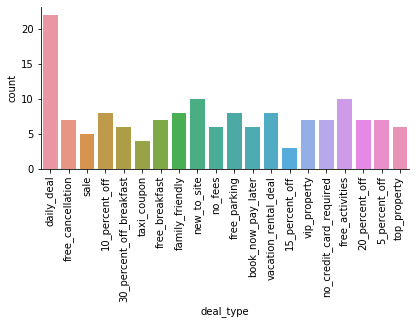

In [619]:
viewed_customer=anony[(anony.viewed_this_property==1)][['user_id','deal_type']].drop_duplicates()
 
plt.figure()
g=sns.catplot(x='deal_type',kind='count',data=viewed_customer,legend_out=True,height=3,aspect=2)
g.set_xticklabels(rotation=90)

<Figure size 432x288 with 0 Axes>

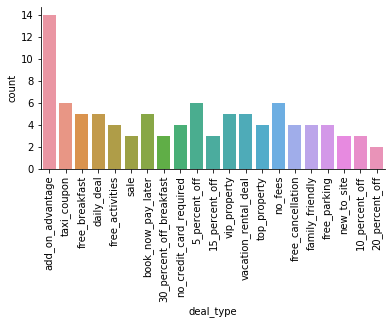

In [620]:
viewed_customer=iden[(iden.viewed_this_property==1)][['user_id','deal_type']].drop_duplicates()

plt.figure()
g=sns.catplot(x='deal_type',kind='count',data=viewed_customer,legend_out=True,height=3,aspect=2)
g.set_xticklabels(rotation=90)


<Figure size 432x288 with 0 Axes>

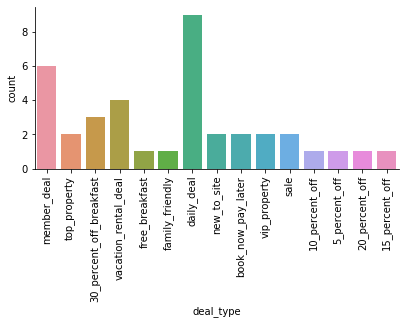

In [621]:
viewed_customer=auth[(auth.viewed_this_property==1)][['user_id','deal_type']].drop_duplicates()

plt.figure()
g=sns.catplot(x='deal_type',kind='count',data=viewed_customer,legend_out=True,height=3,aspect=2)
g.set_xticklabels(rotation=90)

In [ ]:
# Correlation matrix

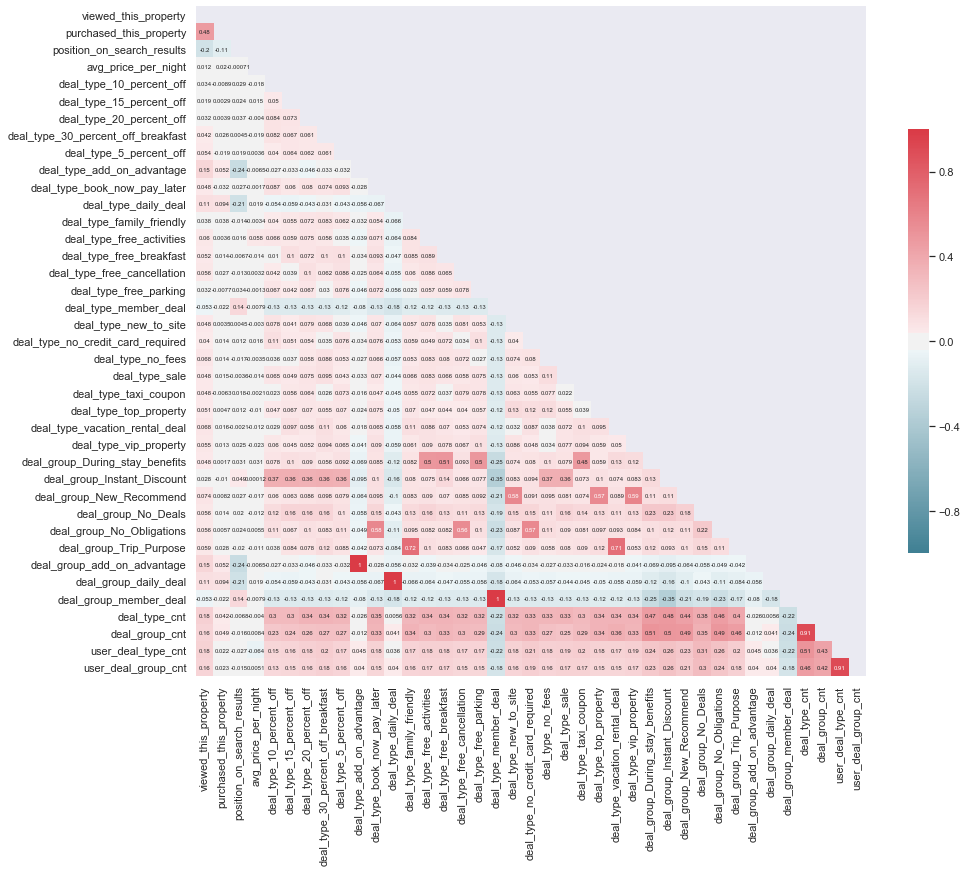

In [779]:
# Generate a mask for the upper triangle

mask = np.zeros_like(df_all.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 13))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(font_scale=1)
sns.heatmap(df_all.corr(),
            vmin=-1,
            cmap=cmap,square=True,mask=mask,
            annot=True,annot_kws={"size": 6},cbar_kws={"shrink": .6},ax=ax)
f = plt.figure()
f.clear()
plt.close(f)
sns.set()

## ML Modeling
### Identify top predictors of viewing and booking action

In [710]:


import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from pdpbox import pdp, info_plots


In [549]:
df_all.columns

Index(['log_in_state', 'user_id', 'property_id', 'viewed_this_property',
       'purchased_this_property', 'position_on_search_results',
       'avg_price_per_night', 'deal_type_10_percent_off',
       'deal_type_15_percent_off', 'deal_type_20_percent_off',
       'deal_type_30_percent_off_breakfast', 'deal_type_5_percent_off',
       'deal_type_add_on_advantage', 'deal_type_book_now_pay_later',
       'deal_type_daily_deal', 'deal_type_family_friendly',
       'deal_type_free_activities', 'deal_type_free_breakfast',
       'deal_type_free_cancellation', 'deal_type_free_parking',
       'deal_type_member_deal', 'deal_type_new_to_site',
       'deal_type_no_credit_card_required', 'deal_type_no_fees',
       'deal_type_sale', 'deal_type_taxi_coupon', 'deal_type_top_property',
       'deal_type_vacation_rental_deal', 'deal_type_vip_property',
       'deal_group_During_stay_benefits', 'deal_group_Instant_Discount',
       'deal_group_New_Recommend', 'deal_group_No_Deals',
       'deal_grou

In [639]:
# all features
var1=['position_on_search_results',
       'avg_price_per_night', 'deal_type_10_percent_off',
       'deal_type_15_percent_off', 'deal_type_20_percent_off',
       'deal_type_30_percent_off_breakfast', 'deal_type_5_percent_off',
       'deal_type_add_on_advantage', 'deal_type_book_now_pay_later',
       'deal_type_daily_deal', 'deal_type_family_friendly',
       'deal_type_free_activities', 'deal_type_free_breakfast',
       'deal_type_free_cancellation', 'deal_type_free_parking',
       'deal_type_member_deal', 'deal_type_new_to_site',
       'deal_type_no_credit_card_required', 'deal_type_no_fees',
       'deal_type_sale', 'deal_type_taxi_coupon', 'deal_type_top_property',
       'deal_type_vacation_rental_deal', 'deal_type_vip_property',
       'deal_group_During_stay_benefits', 'deal_group_Instant_Discount',
       'deal_group_New_Recommend', 'deal_group_No_Deals',
       'deal_group_No_Obligations', 'deal_group_Trip_Purpose',
       'deal_group_add_on_advantage', 'deal_group_daily_deal',
       'deal_group_member_deal', 'deal_type_cnt', 'deal_group_cnt']

In [640]:
# features without price & positions
var2=['deal_type_10_percent_off','deal_type_10_percent_off',
       'deal_type_15_percent_off', 'deal_type_20_percent_off',
       'deal_type_30_percent_off_breakfast', 'deal_type_5_percent_off',
       'deal_type_add_on_advantage', 'deal_type_book_now_pay_later',
       'deal_type_daily_deal', 'deal_type_family_friendly',
       'deal_type_free_activities', 'deal_type_free_breakfast',
       'deal_type_free_cancellation', 'deal_type_free_parking',
       'deal_type_member_deal', 'deal_type_new_to_site',
       'deal_type_no_credit_card_required', 'deal_type_no_fees',
       'deal_type_sale', 'deal_type_taxi_coupon', 'deal_type_top_property',
       'deal_type_vacation_rental_deal', 'deal_type_vip_property',
       'deal_group_During_stay_benefits', 'deal_group_Instant_Discount',
       'deal_group_New_Recommend', 'deal_group_No_Deals',
        'deal_group_Trip_Purpose',
       'deal_group_add_on_advantage', 'deal_group_daily_deal',
       'deal_group_member_deal']

In [699]:
# user level features
var3=['viewed_cnt', 'view_avg_search_position',
       'view_avg_price_per_night',
       'view_deal_type_10_percent_off',
       'view_deal_type_15_percent_off', 'view_deal_type_20_percent_off',
       'view_deal_type_30_percent_off_breakfast',
       'view_deal_type_5_percent_off', 'view_deal_type_add_on_advantage',
       'view_deal_type_book_now_pay_later', 'view_deal_type_daily_deal',
       'view_deal_type_family_friendly', 'view_deal_type_free_activities',
       'view_deal_type_free_breakfast', 'view_deal_type_free_cancellation',
       'view_deal_type_free_parking', 'view_deal_type_member_deal',
       'view_deal_type_new_to_site', 'view_deal_type_no_credit_card_required',
       'view_deal_type_no_fees', 'view_deal_type_sale',
       'view_deal_type_taxi_coupon', 'view_deal_type_top_property',
       'view_deal_type_vacation_rental_deal', 'view_deal_type_vip_property',
       'view_deal_group_During_stay_benefits',
       'view_deal_group_Instant_Discount', 'view_deal_group_New_Recommend',
       'view_deal_group_No_Obligations',
       'view_deal_group_Trip_Purpose', 'view_deal_group_add_on_advantage',
       'view_deal_group_daily_deal', 'view_deal_group_member_deal',
       'user_deal_type_cnt', 'user_deal_group_cnt']

In [717]:
def decision_tree(df_all,deal_only,loginstate,feature_cols,target):
    
    if deal_only=='Y':
        feature_cols=var2
    elif deal_only=='N':
        feature_cols=var1
    else:
        feature_cols=feature_cols
    
    X=pd.get_dummies(df_all[(df_all.log_in_state==loginstate)][feature_cols],drop_first=False) # Features

    #X=X.fillna(0)

    #X=df_all2[feature_cols]
    y = df_all[df_all.log_in_state==loginstate][target] # Target 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21) # 80% training and 20% test

    # Create Decision Tree classifer object
    clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5,class_weight='balanced')

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_train)

    
    print("Train Accuracy:",metrics.accuracy_score(y_train, y_pred))
    print('Train ROC score: {}'.format(roc_auc_score(y_train, y_pred)))
    
    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print('Test ROC score: {}'.format(roc_auc_score(y_test, y_pred)))
    
    return X,clf


def plot_trees(X,clf,output):
    new_fea_cols=X.columns
    graph = Source(tree.export_graphviz(clf, out_file=None
       , feature_names=new_fea_cols, class_names=['0', '1'] 
       , filled = True))

    display(SVG(graph.pipe(format='svg')))
    png_bytes = graph.pipe(format='png')
    
    if output=='Y':
        with open('/Users/cxue200/authe_purchase_tree.png','wb') as f:
            f.write(png_bytes)        

## User level prediction for purchase

Train Accuracy: 0.8837209302325582
Train ROC score: 0.8856209150326797
Test Accuracy: 0.8181818181818182
Test ROC score: 0.7708333333333333


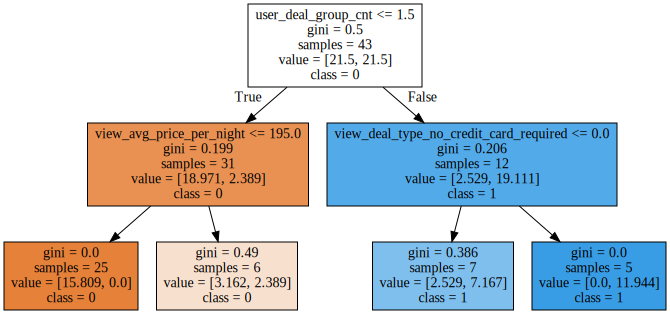

In [718]:
# anonymous
X,clf=decision_tree(df_user,'','anonymous',var3,'purchase_flag')
plot_trees(X,clf,'N')

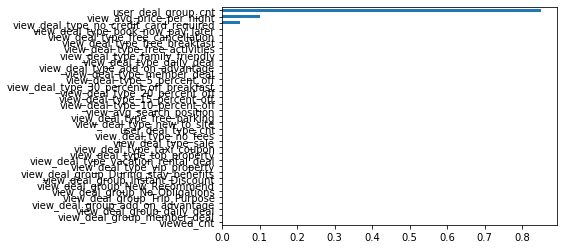

In [703]:
feat_importances = pandas.Series(clf.feature_importances_, index=var3)
feat_importances.sort_values().plot(kind='barh')
plt.show()

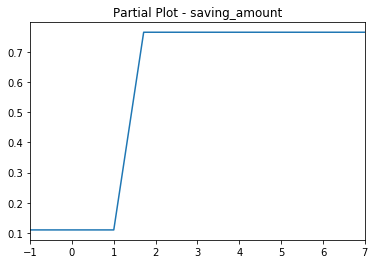

In [711]:
#viwed deal types
pdp_iso = pdp.pdp_isolate(model=clf, 
                          dataset=df_user.drop('purchase_flag', axis=1),      
                          model_features=list(var3),feature='user_deal_group_cnt',num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Partial Plot - Number of deal types viewed')
plt.show()

Train Accuracy: 0.8333333333333334
Train ROC score: 0.85
Test Accuracy: 0.2
Test ROC score: 0.25


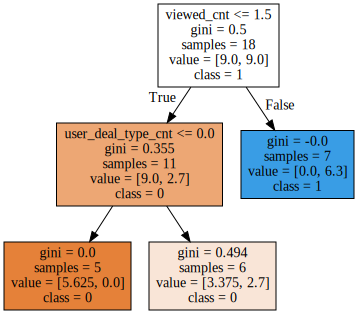

In [719]:
# authenticated
X,clf=decision_tree(df_user,'','authenticated',var3,'purchase_flag')
plot_trees(X,clf,'N')

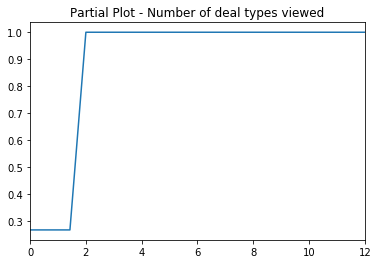

In [721]:
#viwed deal types
pdp_iso = pdp.pdp_isolate(model=clf, 
                          dataset=df_user.drop('purchase_flag', axis=1),      
                          model_features=list(var3),feature='viewed_cnt',num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Partial Plot - Number of deal types viewed')
plt.show()

### purchase prediction with all predictors


In [ ]:
# anonymous
X,clf=decision_tree(df_user,'N','anonymous',feature_cols,'purchased_this_property')
plot_trees(X,clf,'N')

Accuracy: 0.9798657718120806
ROC score: 0.49324324324324326


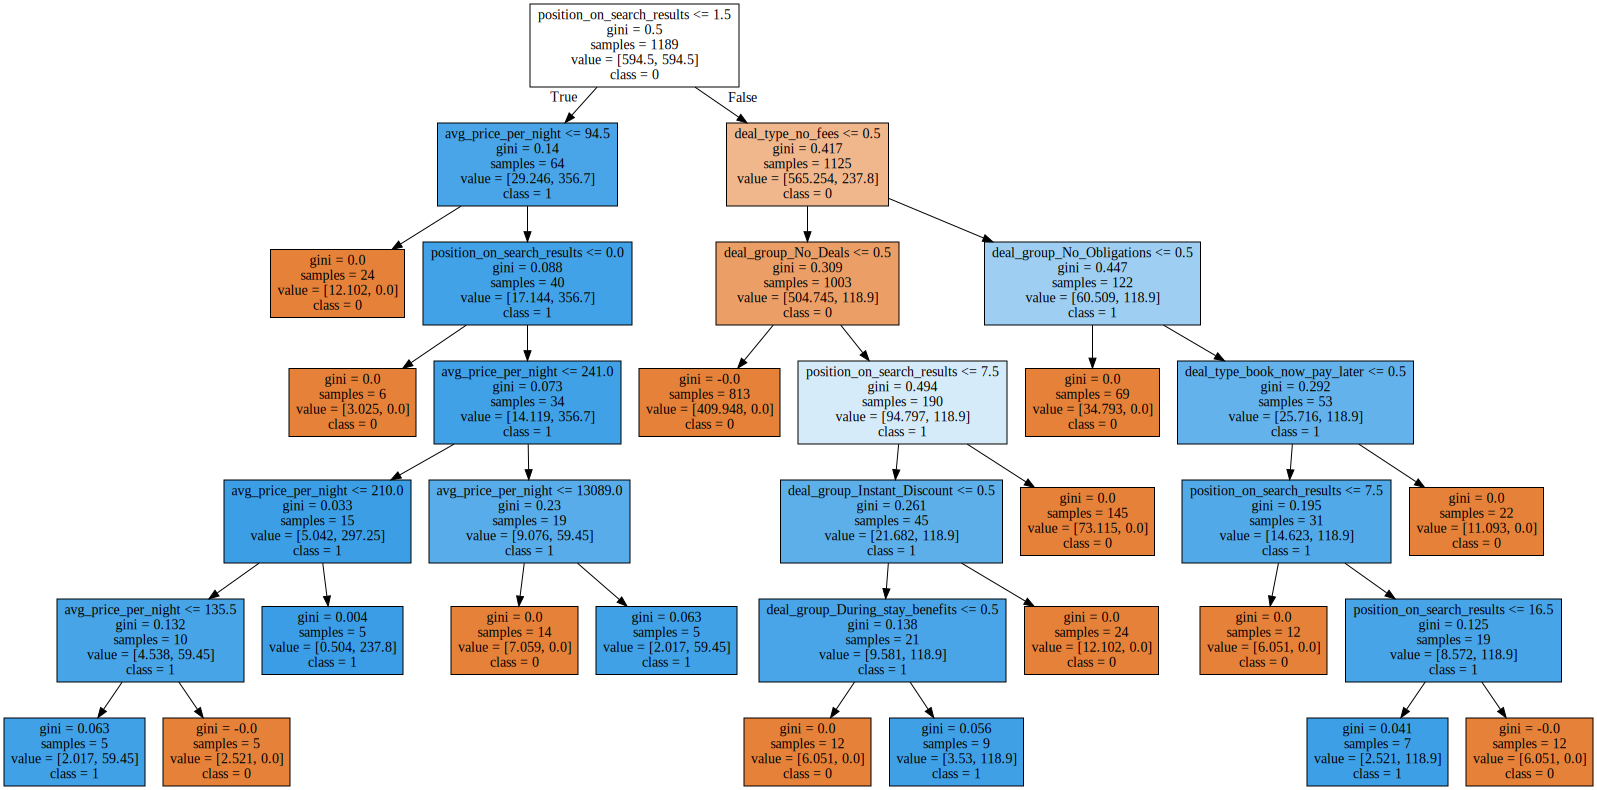

In [658]:
# anonymous
X,clf=decision_tree(df_all,'N','anonymous',feature_cols,'purchased_this_property')
plot_trees(X,clf,'N')

Accuracy: 0.8951612903225806
ROC score: 0.45491803278688525


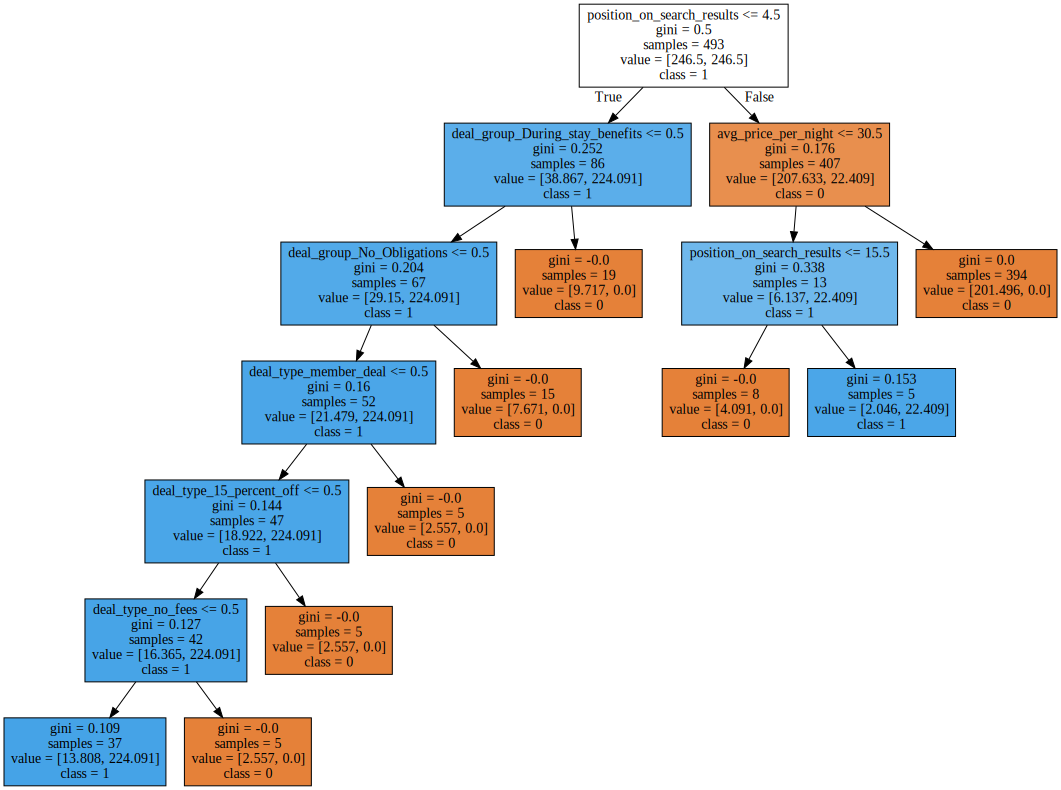

In [659]:
# purchase prediction with all predictors
# authenticated
X,clf=decision_tree(df_all,'N','authenticated',feature_cols,'purchased_this_property')
plot_trees(X,clf,'N')

Accuracy: 0.8984771573604061
ROC score: 0.45618556701030927


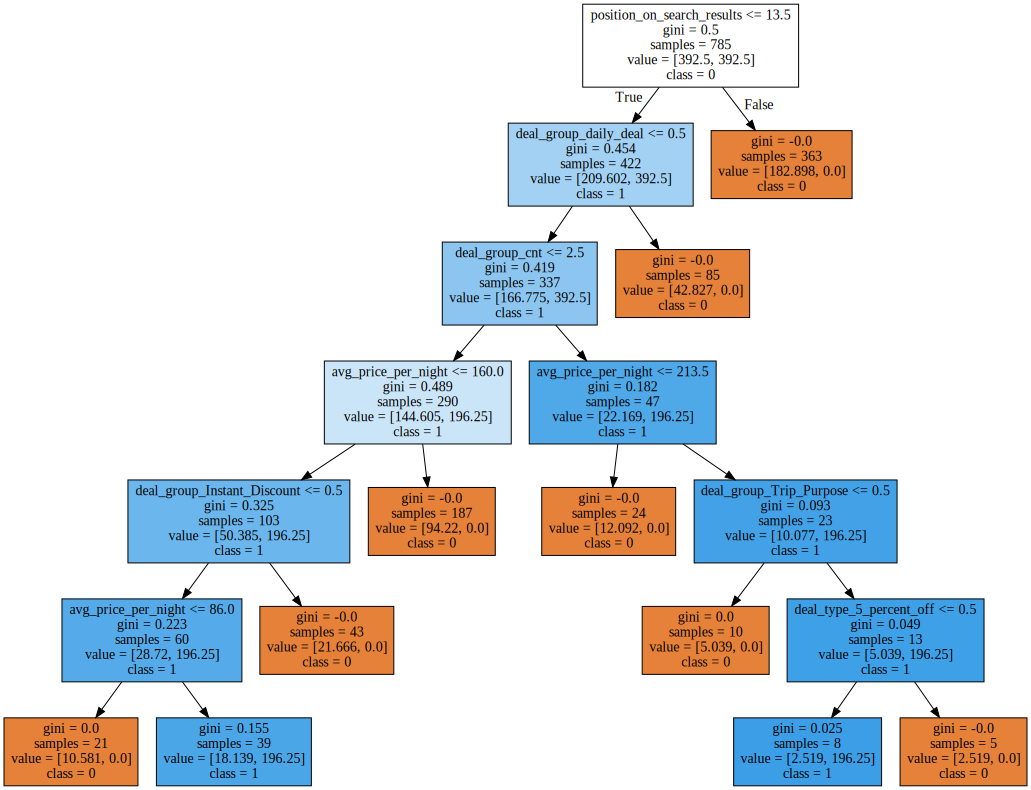

In [660]:
# purchase prediction with all predictors
# identified
X,clf=decision_tree(df_all,'N','identified',feature_cols,'purchased_this_property')
plot_trees(X,clf,'N')

### purchase prediction with only deals related predictors


Accuracy: 0.8489932885906041
ROC score: 0.6756756756756757


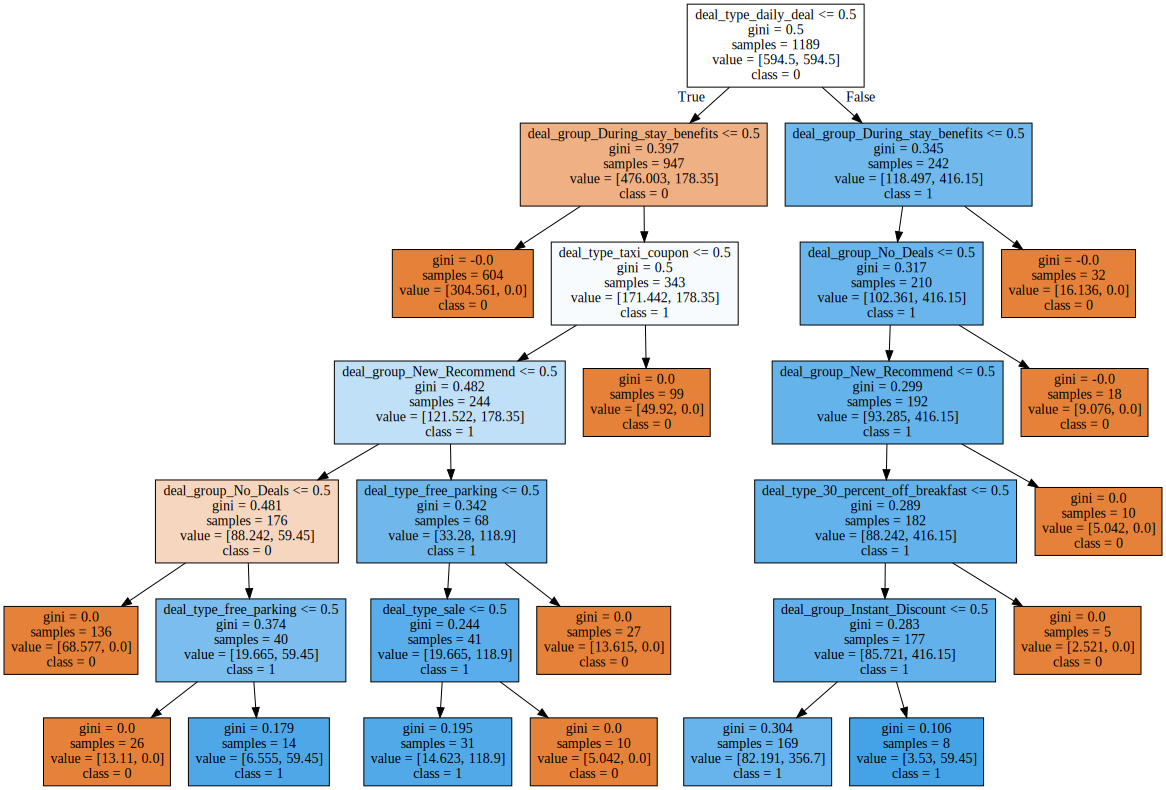

In [661]:
# purchase prediction with only deals related predictors
# anonymous
X,clf=decision_tree(df_all,'Y','anonymous',feature_cols,'purchased_this_property')
plot_trees(X,clf,'N')

Accuracy: 0.8984771573604061
ROC score: 0.45618556701030927


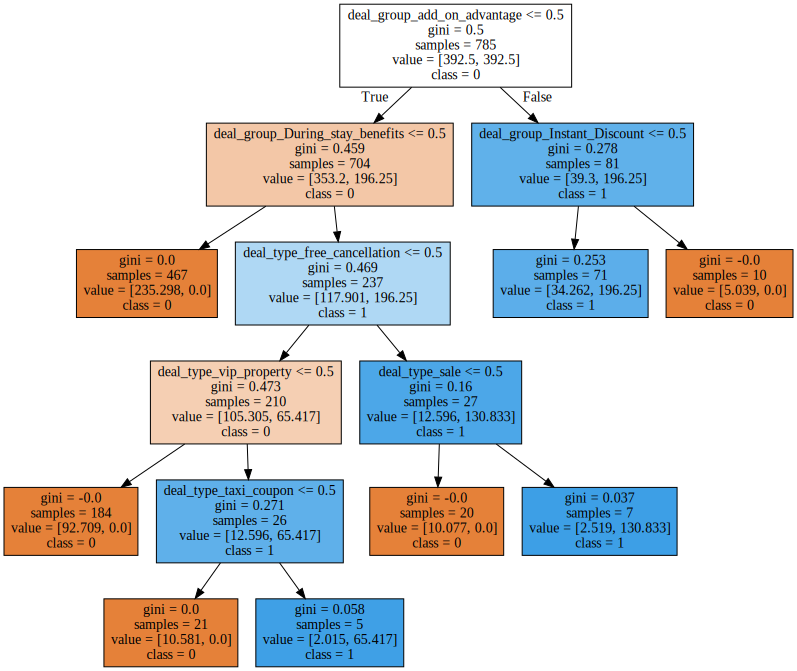

In [647]:
# identified
X,clf=decision_tree(df_all,'Y','identified',feature_cols,'purchased_this_property')
plot_trees(clf,'N')

Accuracy: 0.8629032258064516
ROC score: 0.4385245901639344


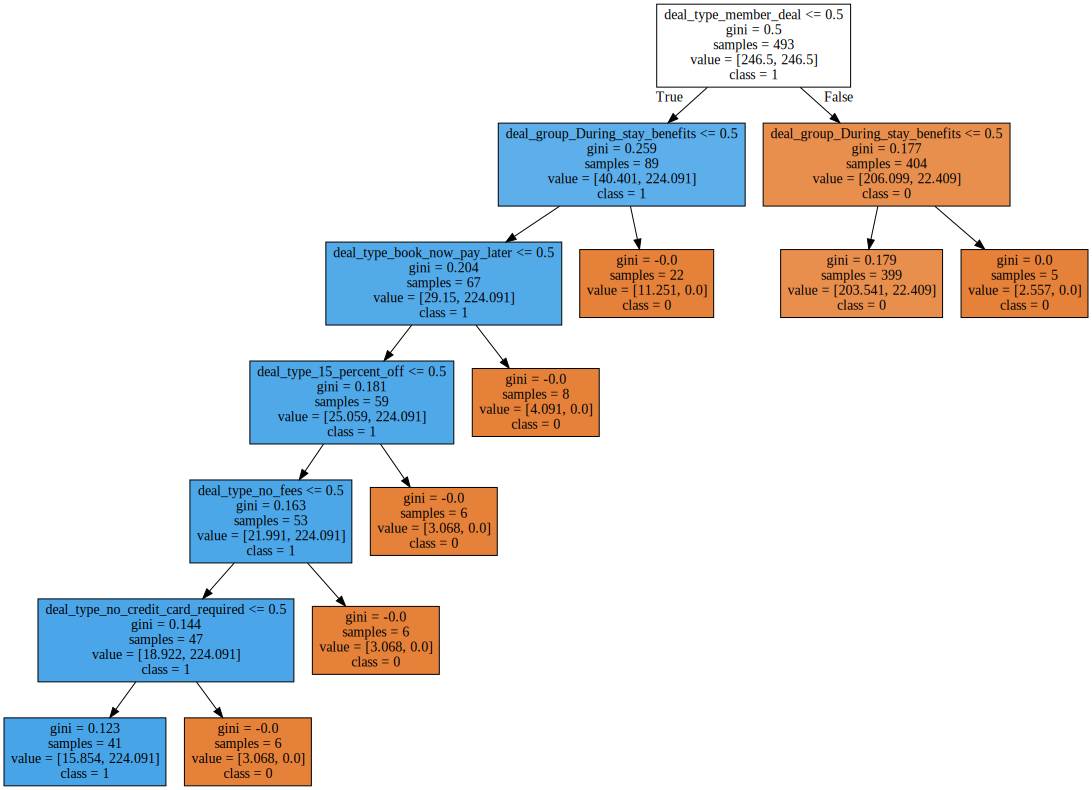

In [648]:
# purchase prediction with only deals related predictors
# authenticated
clf=decision_tree(df_all,'Y','authenticated',feature_cols,'purchased_this_property')
plot_trees(clf,'N')